# MaskRCNN Predictions | HuBMAP - Hacking the Human Vasculature Competition

[EDA](https://www.kaggle.com/code/khalilrejiba/hubmap-vasculature-eda-interactive) | [Train](https://www.kaggle.com/code/khalilrejiba/hubmap-vasculature-maskrcnn-train)

## Utility Scripts

In [1]:
!pip install -q --no-index --no-deps /kaggle/input/hubmap-vasculature-maskrcnn-starter/wheels/pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl

In [2]:
%%bash
cp /kaggle/input/hubmap-vasculature-maskrcnn-starter/utils.py /kaggle/working
cp /kaggle/input/hubmap-vasculature-maskrcnn-starter/engine.py /kaggle/working
cp /kaggle/input/hubmap-vasculature-maskrcnn-starter/coco_eval.py /kaggle/working
cp /kaggle/input/hubmap-vasculature-maskrcnn-starter/coco_utils.py /kaggle/working
cp /kaggle/input/hubmap-vasculature-maskrcnn-starter/transforms.py /kaggle/working

## Import Statements

In [3]:
import numpy as np
import pandas as pd
import json
from pathlib import Path
import gc
import matplotlib.pyplot as plt
import PIL
import skimage
from shapely.geometry import LinearRing as ShapelyContour
from shapely.geometry import Polygon as ShapelyPolygon
import random

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import albumentations as A
from albumentations.pytorch import ToTensorV2

from pycocotools import _mask as coco_mask
import base64
import zlib

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Setting Global Variables

In [4]:
# For reproducibility
seed = 123
random.seed(seed) # Used in Albumentations
np.random.seed(seed)
torch.manual_seed(seed);

In [5]:
TRAIN_DIR = "/kaggle/input/hubmap-hacking-the-human-vasculature/train"
TEST_DIR = "/kaggle/input/hubmap-hacking-the-human-vasculature/test"
ANNOT_PATH = "/kaggle/input/hubmap-hacking-the-human-vasculature/polygons.jsonl"
WSI_TILE_CSV = "/kaggle/input/hubmap-hacking-the-human-vasculature/tile_meta.csv"
IMG_SIZE = 512

In [6]:
hidden_test_ids = [path.stem for path in Path(TEST_DIR).glob("*.tif")]

In [7]:
class_names = ["background", "blood_vessel", "glomerulus", "unsure"]

## Preprocessing

In [8]:
class HuBMAPVasculatureTestset(Dataset):
    
    def __init__(self, ids, root=TEST_DIR, transforms=None):
        self.root = root
        self.ext = "tif"
        self.ids = ids
        self.transforms = transforms

    def __getitem__(self, idx):
        img_path = Path(self.root) / f"{self.ids[idx]}.{self.ext}"
        img = PIL.Image.open(img_path).convert("RGB")
        img = np.array(img)
        if self.transforms is not None:
            img = self.transforms(image=img)["image"]
        return img / 255

    def __len__(self):
        return len(self.ids)

In [9]:
def get_instance_segmentation_model(num_classes=2, hidden_layer=256):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    return model

In [10]:
def get_transforms_pred(s=IMG_SIZE):
    transforms = [
        A.Resize(height=s, width=s),
        ToTensorV2()
    ]    
    transforms = A.Compose(transforms)
    return transforms

## Making Predicitons 

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
SAVE_PATH = "/kaggle/input/hubmap-vasculature-maskrcnn-train/maskrcnn_resnet50_fpn_finetune_10epochs.pth"
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=None, weights_backbone=None)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(class_names))
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                   256,
                                                   len(class_names))
model.to(device)
model.load_state_dict(torch.load(SAVE_PATH))

<All keys matched successfully>

In [12]:
def apply_nms_box(boxes, scores, iou_thres=0.5):
    """
    Non Maximum Suppression using bounding boxes
    """
    x0 = boxes[:, 0]
    y0 = boxes[:, 1]
    x1 = boxes[:, 2]
    y1 = boxes[:, 3]

    areas = (x1 - x0) * (y1 - y0)

    indices = scores.argsort(descending=True)
 
    revised_indices = []
    
    while len(indices) > 0:
        
        idx = indices[0]
        indices = indices[1:]
        revised_indices.append(idx.item())
        
        xx0 = torch.max(x0[indices], x0[idx])
        yy0 = torch.max(y0[indices], y0[idx])
        xx1 = torch.min(x1[indices], x1[idx])
        yy1 = torch.min(y1[indices], y1[idx])
         
        w = torch.clamp(xx1 - xx0, min=0)
        h = torch.clamp(yy1 - yy0, min=0)
        intersection = w * h
        union = areas[indices] - intersection
        IoU = intersection / union

        indices = indices[IoU < iou_thres]

    return revised_indices

In [13]:
def apply_nms_mask(masks, scores, iou_thres=0.5):
    """
    Non Maximum Suppression using masks
    """
    indices = scores.argsort(descending=True)
 
    revised_indices = []
    
    while len(indices) > 0:
        
        idx = indices[0]
        indices = indices[1:]
        revised_indices.append(idx.item())
         
        intersection = masks[indices] * masks[idx]
        union = masks[indices] + masks[idx]
        union = union.clip(0, 1)

        IoU = intersection.sum(dim=(1, 2, 3)) / union.sum(dim=(1, 2, 3))

        indices = indices[IoU < iou_thres]

    return revised_indices

In [14]:
def get_predictions(model, img, label=1, conf_thres=0.5, iou_thres=0.6, nms_mask=True):
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
    prediction = prediction[0]
    
    conf_filter = prediction['scores'] > conf_thres
    label_filter = prediction['labels'] == label
    for k, v in prediction.items():    
        prediction[k] = v[conf_filter * label_filter]
    
    masks = prediction['masks']
    boxes = prediction['boxes']
    scores = prediction['scores']
    
    # Soft Masks to Binary Masks
    masks = (masks >  0.5).byte()
    
    # Non Maximum Suppression
    if nms_mask:
        indices = apply_nms_mask(masks, scores, iou_thres)
    else:
        indices = apply_nms_box(boxes, scores, iou_thres)

    return masks[indices].cpu().numpy(), boxes[indices].cpu().numpy(), scores[indices].cpu().numpy()

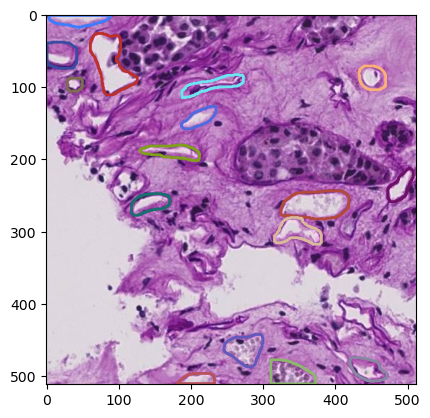

In [15]:
test_dataset = HuBMAPVasculatureTestset(hidden_test_ids, transforms=get_transforms_pred())

img = test_dataset[np.random.randint(len(test_dataset))]

plt.imshow(img.permute(1, 2, 0))

masks, _, scores = get_predictions(model, img)

for mask in masks:
    mask = mask.squeeze()
    polygon = skimage.measure.find_contours(mask)[0]
    yy, xx = zip(*polygon)
    plt.fill(xx, yy, facecolor='none', edgecolor=np.random.random(size=3), linewidth=2)

#  Submission

In [16]:
def encode_mask(mask):
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str

In [17]:
submission_list = []
for i, test_id in enumerate(hidden_test_ids):
    prediction_string = ""
    
    img = test_dataset[i]
    _, h, w = img.shape
    masks, _, scores = get_predictions(model, img)
    masks_glomerulus, _, _ = get_predictions(model, img, label=2)
    
    for mask, score in zip(masks, scores):
        
        # Test if vessel is mainly outside glomerulus
        mask_valid = True
        for glm_msk in masks_glomerulus:
            intersection = mask * glm_msk
            if intersection.sum() < 0.5 * mask.sum():
                continue
            else:
                mask_valid = False
                break
        
        if mask_valid:
            mask = mask.squeeze()
            mask_str = encode_mask(mask).decode('UTF-8')
            prediction_string += f"0 {score} {mask_str} "
            
    entry = {
        "id": test_id,
        "height": h,
        "width": w,
        "prediction_string": prediction_string,
    }
    submission_list.append(entry)

In [18]:
submission_df = pd.DataFrame(submission_list)
submission_df = submission_df.set_index('id')
submission_df.to_csv("submission.csv")

In [19]:
submission_df.head()

,height,width,prediction_string
id,,,
72e40acccadf,512,512,0 0.9840452671051025 eNqLyQgytUyxN/E18jX2N/Iz9...


Modified from: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html